In [37]:
import pandas as pd
import numpy as np
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from header import *

In [38]:
data_root = initialize_data_root("AH")

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

## Import

In [40]:
q3mergeddata = pd.read_csv(data_root + '02-build/clean/2019q3/2019q3merged.csv')

## Hyperparameter Tuning of Random Forest

In [41]:
q3mergeddata['Clean_Number_of_Shares'] = q3mergeddata[['WeightedAverageNumberOfDilutedSharesOutstanding',
       'WeightedAverageNumberOfSharesOutstandingBasic']].max(axis = 1)

q3mergeddata['Clean_Number_of_Shares'] = q3mergeddata[['Clean_Number_of_Shares',
                                                       'CommonStockSharesOutstanding']].max(axis = 1)

q3mergeddata['Company_Value'] = q3mergeddata['Clean_Number_of_Shares'] * q3mergeddata['7_after']
q3mergeddata = q3mergeddata.drop(q3mergeddata[q3mergeddata.Company_Value == 0].index)
q3mergeddata = q3mergeddata.drop(['CommonStockSharesOutstanding','WeightedAverageNumberOfDilutedSharesOutstanding','WeightedAverageNumberOfSharesOutstandingBasic' ], axis = 1)
q3mergeddata['Company_Size_1'] = np.where(q3mergeddata['Company_Value'] <= 2000000000, 1, 0)
q3mergeddata['Company_Size_2'] = np.where(q3mergeddata['Company_Value'] >= 10000000000, 2, 1)
q3mergeddata['Company_Size'] = q3mergeddata['Company_Size_2'] - q3mergeddata['Company_Size_1']

q3mergeddata = q3mergeddata.drop(['Company_Size_1','Company_Size_2'], axis = 1)

q3mergeddata_processed  = pd.DataFrame(preprocessing.scale(q3mergeddata[q3mergeddata.columns[10:len(q3mergeddata.columns) - 7]]), columns =q3mergeddata.columns[10:len(q3mergeddata.columns) - 7] )




/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [51]:
q3mergeddata.head()

,AccountsPayableCurrent,AccountsReceivableNetCurrent,AccruedLiabilitiesCurrent,AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment,AccumulatedOtherComprehensiveIncomeLoss,AdditionalPaidInCapital,AdjustmentsToAdditionalPaidInCapitalSharebasedCompensationRequisiteServicePeriodRecognitionValue,AllowanceForDoubtfulAccountsReceivableCurrent,AntidilutiveSecuritiesExcludedFromComputationOfEarningsPerShareAmount,Assets,...,Revenue,ShareBasedCompensation,Short Term Investments,StockIssuedDuringPeriodValue,StockholdersEquity,SubleaseIncome,TotalLiabilities,TreasuryStockShares,TreasuryStockValue,Company_Size
0,1.169830e+08,7.449900e+07,0.0,9.764000e+07,0.000000e+00,1.249700e+07,0.0,117000.0,0.0,3.017640e+08,...,4.844330e+08,74000.0,0.0,0.0,1.501080e+08,0.0,1.516560e+08,0.0,0.000000e+00,0
1,8.280000e+08,1.333000e+09,727000000.0,7.450000e+08,0.000000e+00,9.325000e+09,0.0,0.0,0.0,5.102000e+09,...,1.531000e+09,45000000.0,0.0,0.0,1.901000e+09,0.0,0.000000e+00,5000000.0,5.000000e+07,2
2,1.543200e+09,1.340700e+09,0.0,1.199800e+10,-1.781400e+09,1.059900e+09,17300000.0,0.0,0.0,1.953190e+10,...,2.224000e+09,9800000.0,0.0,0.0,1.172660e+10,0.0,7.805300e+09,29100445.0,2.033700e+09,2
3,0.000000e+00,0.000000e+00,0.0,0.000000e+00,-9.500000e+04,3.236500e+07,0.0,0.0,0.0,1.276471e+09,...,5.593200e+07,0.0,0.0,0.0,2.686100e+08,0.0,1.007861e+09,66160.0,3.680000e+05,1
4,4.318000e+06,6.285000e+06,6097000.0,0.000000e+00,0.000000e+00,1.975600e+07,0.0,0.0,0.0,3.995190e+08,...,5.756500e+07,0.0,0.0,0.0,1.832830e+08,0.0,2.162360e+08,946114.0,3.220500e+07,0


In [50]:
q3mergeddata = q3mergeddata.drop(['7_before', '7_after', 'difference', 'per', 'Clean_Number_of_Shares', 'Company_Value',\
                                 'Unnamed: 0', 'adsh', 'company_name', 'dyrqt', 'filed', 'cik', 'sic', 'ticker', 'country', 'period'], axis = 1)

In [84]:
X_dt = pd.DataFrame(q3mergeddata_processed.copy())
Y_dt = pd.DataFrame(q3mergeddata['Company_Size'].copy())


rand_forest = RandomForestClassifier(criterion = 'entropy', oob_score = True)

parameters = {'n_estimators':[75,100,125,150], 'min_samples_split':np.linspace(5, 100, 10, dtype = int, endpoint = True), 'min_samples_leaf':np.linspace(10, 150, 10, dtype = int, endpoint = True)}


model = GridSearchCV(rand_forest, parameters, cv = 10)
model.fit(X_dt, np.ravel(Y_dt))



GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=True, random_state=None,
                                              verbose=0, warm_start=False),
             

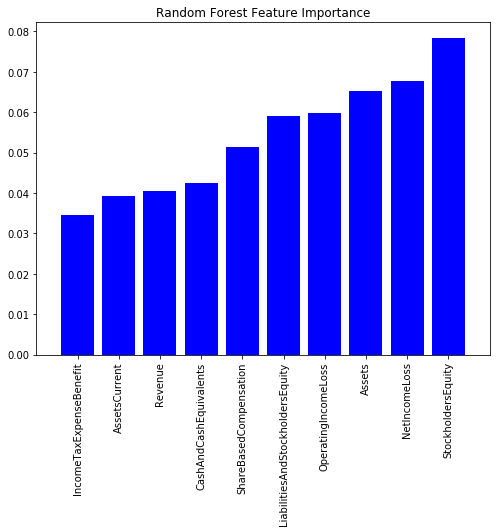

In [151]:
importance = model.best_estimator_.feature_importances_
indices = np.argsort(importance)

plt.figure(figsize=(7,7.5))
plt.title("Random Forest Feature Importance")
plt.bar(X_dt.columns[indices][- 10:], importance[indices][- 10:], 
        color = 'b', align = 'center')
plt.xticks(range(10), X_dt.columns[indices][-10:], rotation = 90)
plt.xlim([-1, 10])

plt.tight_layout()
plt.savefig(data_root + 'Tuned_Random_Forest_Feature_Importance.png')

In [138]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
y_score = model.predict(X_dt)

precision_score(np.ravel(Y_dt), y_score, average = None)

array([0.89874796, 0.78104575, 0.89737171])

In [108]:
recall_score(np.ravel(Y_dt), y_score, average = None)

array([0.94127708, 0.75792812, 0.83957845])

In [126]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'entropy')
parameters = {'min_samples_split' :[2,5,10,25,40,50,100], 'min_samples_leaf': [2,5,10,25,40,50,100]}
model2 = GridSearchCV(dt, parameters, cv = 10)
model2.fit(X_dt, np.ravel(Y_dt))


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_leaf': [2, 5, 10, 25, 40, 50, 100],
                         'min_samples_split': [2, 5, 10, 2

In [127]:
model2.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [ ]:
y_score2 = model2.predict(X_dt)

precision2 = precision_score(np.ravel(Y_dt),y_score2, average = None)
recall2 = recall_score(np.ravel(Y_dt),y_score2, average = None)
cross_val_score(model2,X_dt, np.ravel(Y_dt),cv =10, scoring = 'precision')

In [132]:
precision2

array([0.84878587, 0.59056806, 0.77379481])

In [133]:
recall2

array([0.87685291, 0.58245243, 0.73302108])

OOB Score code but not very sure

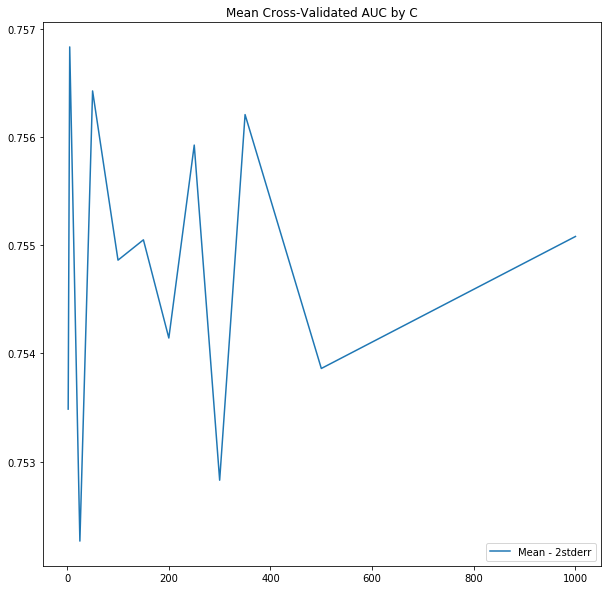

In [83]:
min_samp_split = [2,5,25,50,100,150,200,250,300, 350,500, 1000]

oob_score = []
temp = []
kf = KFold(n_splits = 10)
for train_index, test_index in kf.split(q3mergeddata):
    cv_train, cv_validate = q3mergeddata.iloc[train_index], q3mergeddata.iloc[test_index]
    temp3 = []   
    for c in min_samp_split:    
        rd = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', oob_score = True)
        rd.fit(cv_train.loc[: , cv_train.columns != 'Company_Size'], cv_train['Company_Size'])
        temp3.append(rd.oob_score_)
        
    temp.append(temp3)

for i in range(0, len(min_samp_split)):
    temp2 = [] 
    for j in temp:
        temp2.append(j[i])
    oob_score.append(sum(temp2)/len(temp2))


plt.figure(figsize = (10,10))
plt.title('Mean Cross-Validated AUC by C')
plt.plot(min_samp_split, oob_score,  Label = 'Mean - 2stderr')
plt.legend(loc = 'lower right')
plt.show()

### Do pairwise logistic regression(small medium, small large, medium large)

In [28]:
small_med = q3mergeddata.loc[q3mergeddata.Company_Size != 2]
small_large = q3mergeddata.loc[q3mergeddata.Company_Size != 1]
med_large = q3mergeddata.loc[q3mergeddata.Company_Size != 0]

In [29]:
labels = q3mergeddata.columns[10:len(q3mergeddata.columns) - 7]

log_reg = LogisticRegression(max_iter = 1000)
X = pd.DataFrame(small_med[labels].copy())
Y = pd.DataFrame(small_med.Company_Size.copy())
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30)
log_reg.fit(X_train, np.ravel(Y_train))

logsm_decision = log_reg.decision_function(X_test)
logsm_fpr, logsm_tpr, _  = roc_curve(Y_test, logsm_decision)

logsm_auc = auc(logsm_fpr, logsm_tpr)    

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [30]:
log_reg = LogisticRegression(max_iter = 1000)
X = pd.DataFrame(small_large[labels].copy())
Y = pd.DataFrame(np.where(small_large.Company_Size.copy() == 0, 0, 1))

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30)
log_reg.fit(X_train, np.ravel(Y_train))

logsl_decision = log_reg.decision_function(X_test)
logsl_fpr, logsl_tpr, _  = roc_curve(Y_test, logsl_decision)
logsl_auc = auc(logsl_fpr, logsl_tpr)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [31]:
labels = q3mergeddata.columns[10:len(q3mergeddata.columns) - 7]

log_reg = LogisticRegression(max_iter = 1000)
X = pd.DataFrame(med_large[labels].copy())
Y = pd.DataFrame(np.where(med_large.Company_Size.copy() == 1, 0, 1))
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30)
log_reg.fit(X_train, np.ravel(Y_train))

logml_decision = log_reg.decision_function(X_test)
logml_fpr, logml_tpr, _  = roc_curve(Y_test, logml_decision)

logml_auc = auc(logml_fpr, logml_tpr)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


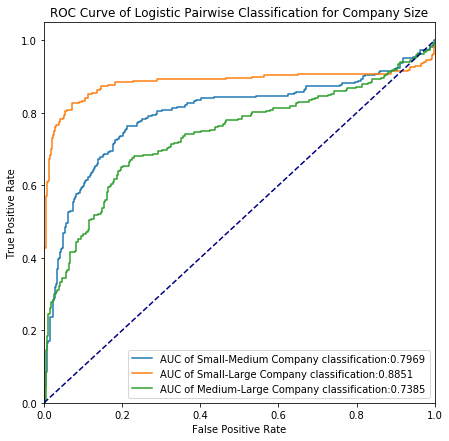

In [32]:
plt.figure(figsize = (7,7))
plt.plot(logsm_fpr, logsm_tpr, label = 'AUC of Small-Medium Company classification:'+"{0:.4f}".format(logsm_auc))
plt.plot(logsl_fpr, logsl_tpr, label = 'AUC of Small-Large Company classification:'+"{0:.4f}".format(logsl_auc))
plt.plot(logml_fpr, logml_tpr, label = 'AUC of Medium-Large Company classification:'+"{0:.4f}".format(logml_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistic Pairwise Classification for Company Size')
plt.legend(loc="lower right")
plt.savefig(data_root+'Pairwise_ComparisonROC.png')

In [33]:
svc = SVC(kernel = 'linear')
X = pd.DataFrame(preprocessing.scale(small_med[labels].copy()))
Y = pd.DataFrame(small_med.Company_Size.copy())
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30)
svc.fit(X_train, np.ravel(Y_train))

svcsm_decision = svc.decision_function(X_test)
svcsm_fpr, svcsm_tpr, _  = roc_curve(Y_test, svcsm_decision)

svcsm_auc = auc(svcsm_fpr, svcsm_tpr)    

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [34]:
svc = SVC(kernel = 'linear')
X = pd.DataFrame(preprocessing.scale(small_large[labels].copy()))
Y = pd.DataFrame(np.where(small_large.Company_Size.copy() == 0, 0, 1))

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30)
svc.fit(X_train, np.ravel(Y_train))

svcsl_decision = svc.decision_function(X_test)
svcsl_fpr, svcsl_tpr, _  = roc_curve(Y_test, svcsl_decision)
svcsl_auc = auc(svcsl_fpr, svcsl_tpr)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [35]:
svc = SVC(kernel = 'linear')
X = pd.DataFrame(preprocessing.scale(med_large[labels].copy()))
Y = pd.DataFrame(np.where(med_large.Company_Size.copy() == 1, 0, 1))
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30)
svc.fit(X_train, np.ravel(Y_train))

svcml_decision = svc.decision_function(X_test)
svcml_fpr, svcml_tpr, _  = roc_curve(Y_test, svcml_decision)

svcml_auc = auc(svcml_fpr, svcml_tpr)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


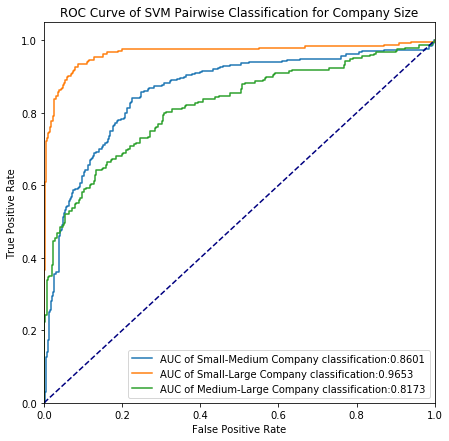

In [36]:
plt.figure(figsize = (7,7))
plt.plot(svcsm_fpr, svcsm_tpr, label = 'AUC of Small-Medium Company classification:'+"{0:.4f}".format(svcsm_auc))
plt.plot(svcsl_fpr, svcsl_tpr, label = 'AUC of Small-Large Company classification:'+"{0:.4f}".format(svcsl_auc))
plt.plot(svcml_fpr, svcml_tpr, label = 'AUC of Medium-Large Company classification:'+"{0:.4f}".format(svcml_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of SVM Pairwise Classification for Company Size')
plt.legend(loc="lower right")
plt.savefig(data_root+'SVMPairwise_ComparisonROC.png')

### Tune Logistic Regression for binary case Rerun import

In [8]:
q3mergeddata['Clean_Number_of_Shares'] = q3mergeddata[['WeightedAverageNumberOfDilutedSharesOutstanding',
       'WeightedAverageNumberOfSharesOutstandingBasic']].max(axis = 1)

q3mergeddata['Clean_Number_of_Shares'] = q3mergeddata[['Clean_Number_of_Shares',
                                                       'CommonStockSharesOutstanding']].max(axis = 1)

q3mergeddata['Company_Value'] = q3mergeddata['Clean_Number_of_Shares'] * q3mergeddata['7_after']
q3mergeddata = q3mergeddata.drop(q3mergeddata[q3mergeddata.Company_Value == 0].index)
q3mergeddata = q3mergeddata.drop(['CommonStockSharesOutstanding','WeightedAverageNumberOfDilutedSharesOutstanding','WeightedAverageNumberOfSharesOutstandingBasic' ], axis = 1)
q3mergeddata['Company_Size'] = np.where(q3mergeddata['Company_Value'] > 5000000000, 1, 0)
q3mergeddata_processed  = pd.DataFrame(preprocessing.scale(q3mergeddata[q3mergeddata.columns[10:len(q3mergeddata.columns) - 7]]), columns =q3mergeddata.columns[10:len(q3mergeddata.columns) - 7] )

c = [1]  

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [9]:
X_dt = pd.DataFrame(q3mergeddata_processed.copy())
Y_dt = pd.DataFrame(q3mergeddata['Company_Size'].copy())

log_reg = LogisticRegression()
parameters = {'penalty':('l1', 'l2'), 'C':c}

model = GridSearchCV(log_reg, parameters, cv = 10)
model.fit(X_dt, np.ravel(Y_dt))

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfg

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1], 'penalty': ('l1', 'l2')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [10]:
model.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X_dt,Y_dt, test_size = 0.30)

log_decision = model.decision_function(X_test)
log_fpr, log_tpr, _  = roc_curve(Y_test, log_decision)

log_auc = auc(log_fpr, log_tpr)

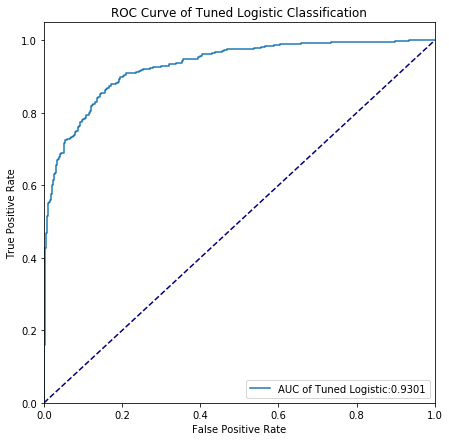

In [12]:
plt.figure(figsize = (7,7))
plt.plot(log_fpr, log_tpr, label = 'AUC of Tuned Logistic:'+"{0:.4f}".format(log_auc))

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Tuned Logistic Classification')
plt.legend(loc="lower right")
plt.savefig(data_root+'TunedLogistic.png')

Tune SVM

In [14]:
q3mergeddata['Clean_Number_of_Shares'] = q3mergeddata[['WeightedAverageNumberOfDilutedSharesOutstanding',
       'WeightedAverageNumberOfSharesOutstandingBasic']].max(axis = 1)

q3mergeddata['Clean_Number_of_Shares'] = q3mergeddata[['Clean_Number_of_Shares',
                                                       'CommonStockSharesOutstanding']].max(axis = 1)

q3mergeddata['Company_Value'] = q3mergeddata['Clean_Number_of_Shares'] * q3mergeddata['7_after']
q3mergeddata = q3mergeddata.drop(q3mergeddata[q3mergeddata.Company_Value == 0].index)
q3mergeddata = q3mergeddata.drop(['CommonStockSharesOutstanding','WeightedAverageNumberOfDilutedSharesOutstanding','WeightedAverageNumberOfSharesOutstandingBasic' ], axis = 1)
q3mergeddata['Company_Size'] = np.where(q3mergeddata['Company_Value'] > 5000000000, 1, 0)
q3mergeddata_processed  = pd.DataFrame(preprocessing.scale(q3mergeddata[q3mergeddata.columns[10:len(q3mergeddata.columns) - 7]]), columns =q3mergeddata.columns[10:len(q3mergeddata.columns) - 7] )

c = [10**i for i in range(-8, 2)]  

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [15]:
X_dt = pd.DataFrame(q3mergeddata_processed.copy())
Y_dt = pd.DataFrame(q3mergeddata['Company_Size'].copy())

svc = SVC(kernel = 'linear')
parameters = {'C':c}

model = GridSearchCV(svc, parameters, cv = 10)
model.fit(X_dt, np.ravel(Y_dt))

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='linear',
                           max_iter=-1, probability=False, random_state=None,
                           shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                               0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X_dt,Y_dt, test_size = 0.30)

svm_decision = model.decision_function(X_test)
svm_fpr, svm_tpr, _  = roc_curve(Y_test, svm_decision)

svm_auc = auc(svm_fpr, svm_tpr)

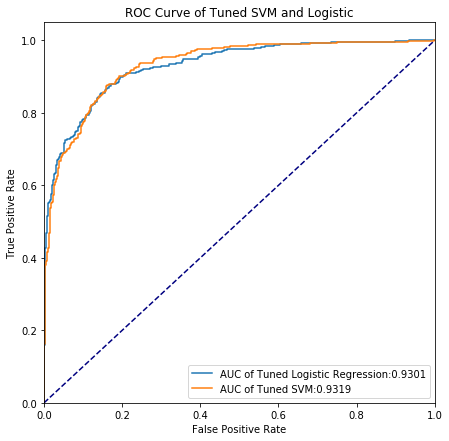

In [18]:
plt.figure(figsize = (7,7))
plt.plot(log_fpr, log_tpr, label = 'AUC of Tuned Logistic Regression:'+"{0:.4f}".format(log_auc))
plt.plot(svm_fpr, svm_tpr, label = 'AUC of Tuned SVM:'+"{0:.4f}".format(svm_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Tuned SVM and Logistic')
plt.legend(loc="lower right")
plt.savefig(data_root+'TunedSVMLogistic.png')

Optimize the tree

In [5]:
q3mergeddata['Clean_Number_of_Shares'] = q3mergeddata[['WeightedAverageNumberOfDilutedSharesOutstanding',
       'WeightedAverageNumberOfSharesOutstandingBasic']].max(axis = 1)

q3mergeddata['Clean_Number_of_Shares'] = q3mergeddata[['Clean_Number_of_Shares',
                                                       'CommonStockSharesOutstanding']].max(axis = 1)

q3mergeddata['Company_Value'] = q3mergeddata['Clean_Number_of_Shares'] * q3mergeddata['7_after']
q3mergeddata = q3mergeddata.drop(q3mergeddata[q3mergeddata.Company_Value == 0].index)
q3mergeddata = q3mergeddata.drop(['CommonStockSharesOutstanding','WeightedAverageNumberOfDilutedSharesOutstanding','WeightedAverageNumberOfSharesOutstandingBasic' ], axis = 1)
q3mergeddata['Company_Size'] = np.where(q3mergeddata['Company_Value'] > 5000000000, 1, 0)
q3mergeddata_processed  = pd.DataFrame(preprocessing.scale(q3mergeddata[q3mergeddata.columns[10:len(q3mergeddata.columns) - 7]]), columns =q3mergeddata.columns[10:len(q3mergeddata.columns) - 7] )

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [ ]:
X_dt = pd.DataFrame(q3mergeddata_processed.copy())
Y_dt = pd.DataFrame(q3mergeddata['Company_Size'].copy())

X_train, X_test, Y_train, Y_test = train_test_split(X_dt,Y_dt, test_size = 0.30)
min_samp = [2,5,10,20,50]

min_samp_leaf = [5,10,20,30,40]

for i in range(5):
    for j in range(5):
        dt = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = min_samp[i],min_samples_leaf = min_samp_leaf[j])
        dt.fit(X_train, Y_train)
        test_score = dt.score(X_test, Y_test)
        print(str('{} {} testscore {}'.format(min_samp[i], min_samp_leaf[j], test_score)))






In [10]:
dt.get_params()

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}